## Characterize novel internal exons that we have in PODER vs. GENCODE

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *
from scripts.sm_utils import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
gtf_file = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_file

ref_gtf_file = proc_cfg(config['ref']['gtf'], od)
ref_gtf_file


'../ref/annot.gtf'

In [4]:
# get internal exons from each annotation

In [5]:
def make_exon_id(df):
    """
    Get an ID for each unique exon using 
    Chromosome, Strand, Start, End
    """
    df['eid'] = df['Chromosome'].astype(str)+'_'+\
                df['Strand'].astype(str)+'_'+\
                df['Start'].astype(str)+'_'+\
                df['End'].astype(str)+'_'
    return df
    

In [6]:
# PODER
df = pr.read_gtf(gtf_file).df
df = df.loc[df.Feature=='exon']

# remove first and last exons
df['first_or_last_exon'] = (~df.duplicated('transcript_id', keep='first'))|\
                           (~df.duplicated('transcript_id', keep='last'))
df = df.loc[~df.first_or_last_exon]
df = make_exon_id(df)

# only keep unique exons
df = df[['Chromosome', 'Strand', 'Start', 'End', 'eid']].drop_duplicates(keep='first')

In [7]:
# GENCODE
ref_df = pr.read_gtf(ref_gtf_file).df
ref_df = ref_df.loc[ref_df.Feature=='exon']

# remove first and last exons
ref_df['first_or_last_exon'] = (~ref_df.duplicated('transcript_id', keep='first'))|\
                           (~ref_df.duplicated('transcript_id', keep='last'))
ref_df = ref_df.loc[~ref_df.first_or_last_exon]
ref_df = make_exon_id(ref_df)

# only keep unique exons
ref_df = ref_df[['Chromosome', 'Strand', 'Start', 'End', 'eid']].drop_duplicates(keep='first')

In [8]:
# do a pyranges left join w/ PODER 
df = pr.PyRanges(df)
ref_df = pr.PyRanges(ref_df)
df = df.join(ref_df,
             strandedness='same',
             how='left',
             report_overlap=True,
             slack=0, suffix='_gc')

## How many uniq exons are there in PODER?

In [9]:
df = df.df

In [10]:
# df.to_csv('241031_uniq_poder_exons.tsv', sep='\t')
df.to_csv('241108_uniq_poder_exons.tsv', sep='\t')

In [11]:
n_uniq_poder = len(df.eid.unique())
print(f'{n_uniq_poder} unique internal exons in PODER')

169847 unique internal exons in PODER


## How many exons are completely present in GC?

In [12]:
n_perfect_match = len(list(set(df.eid.tolist())&set(ref_df.eid.tolist())))
print(f'{(n_perfect_match/n_uniq_poder)*100:.2f}% ({n_perfect_match}/{n_uniq_poder}) internal exons have perfect matches in GENCODE v47')

93.89% (159476/169847) internal exons have perfect matches in GENCODE v47


## How many exons are not in GC (not perfect matches)?

In [13]:
no_perfect_match_list = list(set(df.eid.tolist())-set(ref_df.eid.tolist()))
n_no_perfect_match = len(no_perfect_match_list)
print(f'{(n_no_perfect_match/n_uniq_poder)*100:.2f}% ({n_no_perfect_match}/{n_uniq_poder}) internal exons have NO perfect matches in GENCODE v47')

6.11% (10371/169847) internal exons have NO perfect matches in GENCODE v47


## How many no perfect match exons at least overlap a known GC exon (and thus represent alt. 3'/5' splicing)

In [14]:
n_no_perfect_match_overlap = len(df.loc[(df.eid.isin(no_perfect_match_list))&\
                      (df.Overlap<=0)].eid.unique())
print(f'{(n_no_perfect_match_overlap/n_no_perfect_match)*100:.2f}% ({n_no_perfect_match_overlap}/{n_no_perfect_match}) internal exons with NO perfect matches in GENCODE v47 DONT overlap w/ a GENCODE exon')

38.75% (4019/10371) internal exons with NO perfect matches in GENCODE v47 DONT overlap w/ a GENCODE exon


## Plots

In [15]:
temp = df[['eid']].drop_duplicates()
temp['novelty'] = 'Novel'
temp.loc[temp.eid.isin(df.loc[df.Overlap>=1].eid.tolist()), 'novelty'] = "Novel 5'/3'"
temp.loc[temp.eid.isin(df.eid_gc.tolist()), 'novelty'] = 'Known'

In [16]:
temp = temp.groupby('novelty').count().rename({'eid':'n_e'}, axis=1).reset_index()
temp['n_total_e'] = temp.n_e.sum()
temp['perc'] = (temp['n_e']/temp['n_total_e'])*100
temp

,novelty,n_e,n_total_e,perc
0,Known,159476,169847,93.893916
1,Novel,4019,169847,2.366247
2,Novel 5'/3',6352,169847,3.739836


In [17]:
# save table for figure of # uniq exons by novelty
# temp.to_csv('241029_num_exons_by_novelty.tsv', sep='\t', index=False)
temp.to_csv('241108_num_exons_by_novelty.tsv', sep='\t', index=False)

In [18]:
# temp = pd.read_csv('241029_num_exons_by_novelty.tsv', sep='\t')
temp = pd.read_csv('241108_num_exons_by_novelty.tsv', sep='\t')

In [19]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [20]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        tot = df.loc[df.n_e==h, 'perc'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.09)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(f'{tot:.2f}%', (x, y), size = 18)

In [21]:
temp

,novelty,n_e,n_total_e,perc
0,Known,159476,169847,93.893916
1,Novel,4019,169847,2.366247
2,Novel 5'/3',6352,169847,3.739836


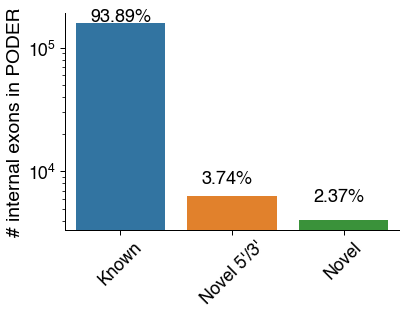

In [22]:
# number of known exons,
# number of novel exons (3'/5' splicing),
# number of novel exons (completely novel)
init_plot_settings(aspect='square')
ax = sns.barplot(temp, y='n_e', 
                 x='novelty', order=['Known', "Novel 5'/3'", 'Novel'])
add_perc_2(ax, temp)
ylabel = '# internal exons in PODER'
ax.set(ylabel=ylabel, xlabel='', yscale='log')
clean_figure(ax)

## But what % of completely novel exons come from known genes?

In [23]:
# df_back = df.copy(deep=True)
df = pd.read_csv('241031_uniq_poder_exons.tsv', sep='\t')

In [24]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
# mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
#                       (mt_df.sample_sharing>1)

In [25]:
# list(mt_df.columns)

In [26]:
temp = df[['eid']].drop_duplicates()
temp['novelty'] = 'Novel'
temp.loc[temp.eid.isin(df.loc[df.Overlap>=1].eid.tolist()), 'novelty'] = "Novel 5'/3'"
temp.loc[temp.eid.isin(df.eid_gc.tolist()), 'novelty'] = 'Known'

In [27]:
# df = pr.read_gtf(gtf_file).df
# df = df.loc[df.Feature=='exon']

# # remove first and last exons
# df['first_or_last_exon'] = (~df.duplicated('transcript_id', keep='first'))|\
#                            (~df.duplicated('transcript_id', keep='last'))
# df = df.loc[~df.first_or_last_exon]
# df = make_exon_id(df)

In [28]:
df = pr.read_gtf(gtf_file).df
df = df.loc[df.Feature=='exon']

# remove first and last exons
df['first_or_last_exon'] = (~df.duplicated('transcript_id', keep='first'))|\
                           (~df.duplicated('transcript_id', keep='last'))
df = df.loc[~df.first_or_last_exon]
df = make_exon_id(df)

In [29]:
# temp = temp.loc[temp.novelty.isin(['Novel', "Novel 5'/3"])]

In [30]:
# add tids from the poder gtfg
temp = temp.merge(df[['transcript_id', 'eid']], 
                  how='left',
                  on='eid')

In [31]:
# list(mt_df.columns)

In [32]:
# add gene biotype, from master table
temp = temp.merge(mt_df[['isoform', 'structural_category', 
                         'associated_gene', 'associated_gene_biotype']],
                  how='left',
                  left_on='transcript_id',
                  right_on='isoform')

In [33]:
temp.loc[temp.transcript_id=='transcript_367606']

,eid,novelty,transcript_id,isoform,structural_category,associated_gene,associated_gene_biotype
299184,chr8_-_90980362_90980461_,Known,transcript_367606,transcript_367606,FSM,ENSG00000289502.1_ENSG00000253250.3,Protein Coding
299185,chr8_-_90978578_90978652_,Known,transcript_367606,transcript_367606,FSM,ENSG00000289502.1_ENSG00000253250.3,Protein Coding
299186,chr8_-_90971065_90971141_,Known,transcript_367606,transcript_367606,FSM,ENSG00000289502.1_ENSG00000253250.3,Protein Coding
299187,chr8_-_90960741_90960848_,Known,transcript_367606,transcript_367606,FSM,ENSG00000289502.1_ENSG00000253250.3,Protein Coding


In [34]:
# # make this into an output table
# temp[['Chromosome', 'Strand', 'Start', 'End', 'temp']] = temp.eid.str.split('_', expand=True)
# # temp.to_csv('241028_novel_exon_table.tsv', sep='\t')
# # temp.to_csv('241029_novel_exon_table.tsv', sep='\t')
# # temp.to_csv('241031_novel_exon_table.tsv', sep='\t')
temp.to_csv('241108_novel_exon_table.tsv', sep='\t')

In [35]:
# temp = pd.read_csv('241031_novel_exon_table.tsv', sep='\t')
temp = pd.read_csv('241108_novel_exon_table.tsv', sep='\t')

In [36]:
# drop dupe
inds = temp.loc[temp.associated_gene_biotype=='Novel/Ambiguous Gene'].index
temp.loc[inds, 'associated_gene_biotype'] = temp.loc[inds, 'structural_category']
temp = temp[['eid', 'novelty', 'associated_gene', 'associated_gene_biotype']].drop_duplicates()

In [37]:
def get_biotype_novelty_colors():
    c_dict_1 = {'Protein Coding': '#287373',
                'lncRNA': '#f89e5c'}
    c_dict, order = get_novelty_colors(['Antisense', 'Fusion', 'Genic', 'Intergenic'])
    c_dict = c_dict.update(c_dict_1)
    order = ['Protein Coding', 'lncRNA']+order
    return c_dict, order

In [38]:
c_dict, order = get_biotype_novelty_colors()

In [39]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        try:
            tot = df.loc[df.n_e_gene==h, 'n_e_gene'].values[0]
            x = p.get_x() + p.get_width() / 2 - (0.05)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(f'{tot}', (x, y), size = 18)
        except: pass

In [40]:
temp.head()

,eid,novelty,associated_gene,associated_gene_biotype
0,GL000008.2_+_83926_84014_,Known,ENSG00000296732.1,lncRNA
12,GL000008.2_+_85456_85477_,Known,ENSG00000296732.1,lncRNA
19,GL000008.2_+_85566_85625_,Known,ENSG00000296732.1,lncRNA
43,GL000008.2_+_88635_88695_,Known,ENSG00000296732.1,lncRNA
50,GL000008.2_+_135133_135173_,Known,ENSG00000296732.1,lncRNA


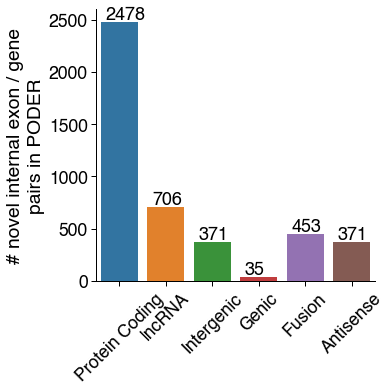

In [41]:
# number of novel exons (completely novel)
temp2 = temp.loc[temp.novelty=='Novel']
temp2 = temp2[['eid', 'associated_gene_biotype']].groupby('associated_gene_biotype').count().reset_index().rename({'eid':'n_e_gene'}, axis=1)

init_plot_settings(aspect='square')
ax = sns.barplot(temp2, y='n_e_gene', 
                 x='associated_gene_biotype',
                 order=order,
                 palette=c_dict)
add_perc_2(ax, temp2)
ylabel = '# novel internal exon / gene\npairs in PODER'
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)

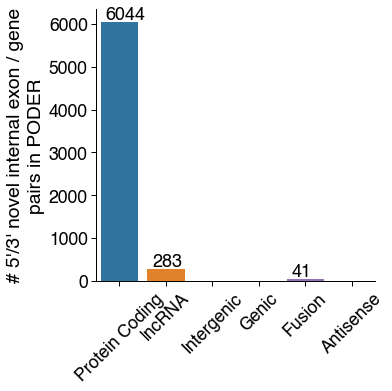

In [42]:
# number of novel exons (3'/5' splicing),
temp2 = temp.loc[temp.novelty=="Novel 5'/3'"]
temp2 = temp2[['eid', 'associated_gene_biotype']].groupby('associated_gene_biotype').count().reset_index().rename({'eid':'n_e_gene'}, axis=1)

init_plot_settings(aspect='square')
ax = sns.barplot(temp2, y='n_e_gene', 
                 x='associated_gene_biotype',
                 order=order,
                 palette=c_dict)
add_perc_2(ax, temp2)
ylabel = "# 5'/3' novel internal exon / gene\npairs in PODER"
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)

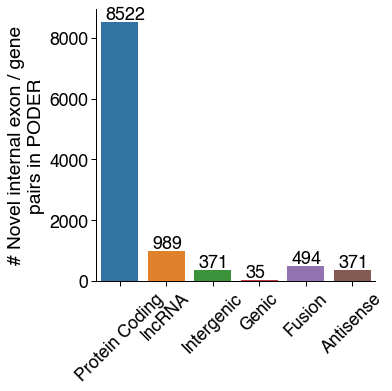

In [43]:
# number of novel exons 3'5' and completely novel,
temp2 = temp.loc[temp.novelty.isin(['Novel', "Novel 5'/3'"])]
temp2 = temp2[['eid', 'associated_gene_biotype']].groupby('associated_gene_biotype').count().reset_index().rename({'eid':'n_e_gene'}, axis=1)

init_plot_settings(aspect='square')
ax = sns.barplot(temp2, y='n_e_gene', 
                 x='associated_gene_biotype',
                 order=order,
                 palette=c_dict)
add_perc_2(ax, temp2)
ylabel = "# Novel internal exon / gene\npairs in PODER"
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)

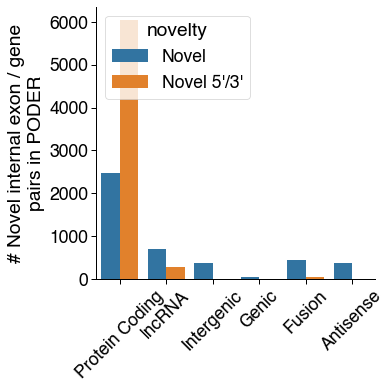

In [44]:
# number of novel exons 3'5' and completely novel,
# split by novelty
temp2 = temp.loc[temp.novelty.isin(['Novel', "Novel 5'/3'"])]
temp2 = temp2[['eid', 'novelty',
               'associated_gene_biotype']].groupby(['associated_gene_biotype',
                                                    'novelty']).count().reset_index().rename({'eid':'n_e_gene'}, axis=1)

init_plot_settings(aspect='square')
ax = sns.barplot(temp2, y='n_e_gene', 
                 x='associated_gene_biotype',
                 hue='novelty',
                 order=order,
                 palette=c_dict)
# add_perc_2(ax, temp2)
ylabel = "# Novel internal exon / gene\npairs in PODER"
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)

In [45]:
temp.head()

,eid,novelty,associated_gene,associated_gene_biotype
0,GL000008.2_+_83926_84014_,Known,ENSG00000296732.1,lncRNA
12,GL000008.2_+_85456_85477_,Known,ENSG00000296732.1,lncRNA
19,GL000008.2_+_85566_85625_,Known,ENSG00000296732.1,lncRNA
43,GL000008.2_+_88635_88695_,Known,ENSG00000296732.1,lncRNA
50,GL000008.2_+_135133_135173_,Known,ENSG00000296732.1,lncRNA


In [46]:
# temp.to_csv('241031_exon_novelty_associated_gene.tsv', sep='\t')
temp.to_csv('241108_exon_novelty_associated_gene.tsv', sep='\t')

## Get table of exons by novelty category as well as by detected in each population

In [47]:
# df = pd.read_csv('241031_novel_exon_table.tsv', sep='\t')
df = pd.read_csv('241108_novel_exon_table.tsv', sep='\t')

In [48]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# meta = load_meta()
# meta = meta.loc[meta.merged_run_mode==True]
# pops = 
_, pops = get_population_colors()
mt_df = mt_df[['isoform']+pops]
mt_df.rename({'isoform':'transcript_id'},
             inplace=True,
             axis=1)

# # melt
# mt_df = mt_df.set_index('isoform')
# mt_df = mt_df.melt(ignore_index=False, 
#                    value_name='detected',
#                    var_name='population')
# print(len(mt_df.index))
# mt_df = mt_df.loc[mt_df.detected>0]
# print(len(mt_df.index))
# mt_df.reset_index(inplace=True)

In [49]:
mt_df.head()

,transcript_id,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI
0,ENST00000741425.1,1,0,0,0,0,0,0,0
1,transcript_0,1,0,0,0,0,0,0,0
2,transcript_1,1,0,0,0,0,0,1,0
3,transcript_10,1,1,0,1,0,0,0,0
4,transcript_11,2,1,0,1,0,0,2,0


In [50]:
# add detection stuff
df = df.merge(mt_df, how='left',
              on='transcript_id')
df.head()

,Unnamed: 0,eid,novelty,transcript_id,isoform,structural_category,associated_gene,associated_gene_biotype,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI
0,0,GL000008.2_+_83926_84014_,Known,ENST00000741425.1,ENST00000741425.1,FSM,ENSG00000296732.1,lncRNA,1,0,0,0,0,0,0,0
1,1,GL000008.2_+_83926_84014_,Known,transcript_1,transcript_1,FSM,ENSG00000296732.1,lncRNA,1,0,0,0,0,0,1,0
2,2,GL000008.2_+_83926_84014_,Known,transcript_10,transcript_10,FSM,ENSG00000296732.1,lncRNA,1,1,0,1,0,0,0,0
3,3,GL000008.2_+_83926_84014_,Known,transcript_11,transcript_11,FSM,ENSG00000296732.1,lncRNA,2,1,0,1,0,0,2,0
4,4,GL000008.2_+_83926_84014_,Known,transcript_12,transcript_12,FSM,ENSG00000296732.1,lncRNA,2,0,0,1,0,0,2,0


In [51]:
print(len(df.eid.unique()))
print(len(df[['eid', 'novelty']].drop_duplicates()))

169847
169847


In [52]:
# get the detection status for each exon
df = df[['eid', 'novelty']+pops]
df = df.groupby(['eid', 'novelty']).max().reset_index()

In [53]:
len(df.index)

169847

In [54]:
# df.to_csv('241103_exons_novelty_pop_det.tsv', sep='\t')
df.to_csv('241108_exons_novelty_pop_det.tsv', sep='\t')